# Exploring `build_bus_regions` outputs

### Jupyter notebook needs to be improved

In [ ]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show

import os
import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import sets_path_to_root
sets_path_to_root("pypsa-africa")

# Input

In [2]:
# Load network
network_path = os.getcwd() + "/networks/base.nc"
n = pypsa.Network(network_path)
n

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import. 
Currently used PyPSA version [0, 18, 1], imported network file PyPSA version [0, 18, 0].

INFO:pypsa.io:Imported network base.nc has buses, lines


Network PyPSA-Eur

<AxesSubplot:>

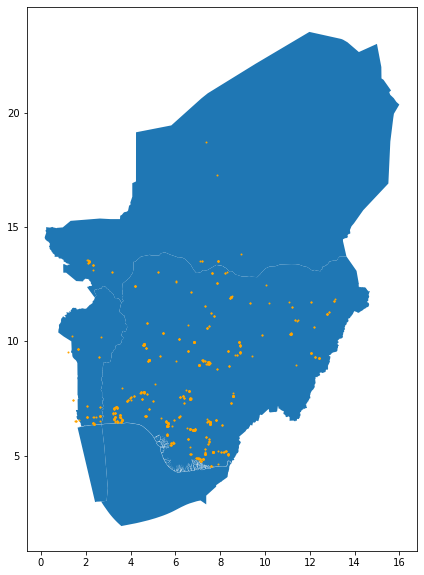

In [3]:
buses = n.buses
# Adding geometries from x and y coordinates
buses["geometry"] = gpd.points_from_xy(buses.lon, buses.lat)
buses = gpd.GeoDataFrame(buses, crs='epsg:4326')

continent = gpd.read_file('resources/country_shapes.geojson')
off_shore = gpd.read_file('resources/offshore_shapes.geojson')

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
buses.plot(ax=ax, color = "orange", markersize = 1)

In [5]:
buses[buses.country=="NG"]

,v_nom,symbol,under_construction,tag_substation,tag_area,lon,lat,country,substation_lv,x,...,substation_off,type,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network,geometry
name,,,,,,,,,,,,,,,,,,,,,
9,220.0,False,False,False,False,2.134682,13.494830,NG,False,2.134682,...,True,,AC,None,1.0,0.0,inf,PQ,,POINT (2.13468 13.49483)
12,220.0,False,False,False,False,7.617533,12.969021,NG,True,7.617533,...,True,,AC,None,1.0,0.0,inf,PQ,,POINT (7.61753 12.96902)
17,300.0,False,False,False,False,3.246816,6.601613,NG,True,3.246816,...,True,,AC,None,1.0,0.0,inf,PQ,,POINT (3.24682 6.60161)
46,300.0,False,False,False,False,4.612316,9.864240,NG,False,4.612316,...,True,,AC,None,1.0,0.0,inf,PQ,,POINT (4.61232 9.86424)
47,300.0,False,False,False,False,5.684414,6.408891,NG,False,5.684414,...,True,,AC,None,1.0,0.0,inf,PQ,,POINT (5.68441 6.40889)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,300.0,False,False,False,False,6.857776,6.144183,NG,False,6.857776,...,True,,AC,None,1.0,0.0,inf,PQ,,POINT (6.85778 6.14418)
988,300.0,False,False,False,False,6.154980,6.702377,NG,False,6.154980,...,True,,AC,None,1.0,0.0,inf,PQ,,POINT (6.15498 6.70238)
989,300.0,False,False,False,False,8.474327,11.927053,NG,False,8.474327,...,True,,AC,None,1.0,0.0,inf,PQ,,POINT (8.47433 11.92705)


# Output

<AxesSubplot:>

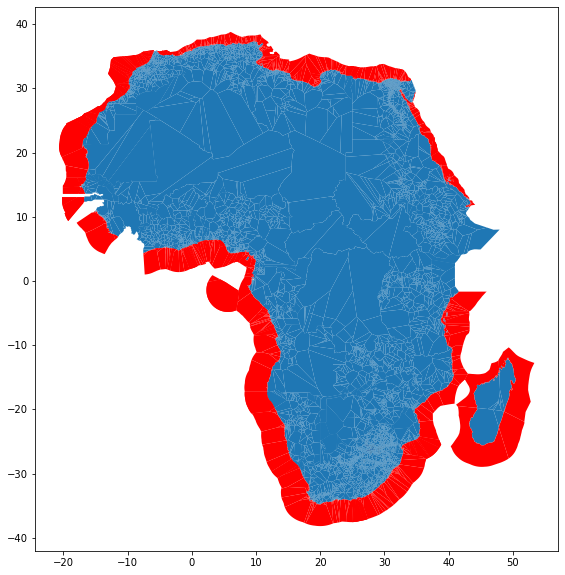

In [6]:
continent = gpd.read_file('resources/regions_onshore.geojson')
off_shore = gpd.read_file('resources/regions_offshore.geojson')

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax, color="red")

In [8]:
c_b = n.buses.country == "NG"
n.buses.substation_off
b = (n.buses.substation_off & c_b)
b.sum()

906

In [9]:
c_b.sum()

906

In [10]:
n.buses.groupby("country").sum()

,v_nom,symbol,under_construction,tag_substation,tag_area,lon,lat,substation_lv,x,y,substation_off,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max
country,,,,,,,,,,,,,,
BJ,12800.0,0,0,0,0,122.712527,402.220041,19,122.712527,402.220041,56,56.0,0.0,NaN
NE,6600.0,0,0,0,0,122.869925,412.237631,16,122.869925,412.237631,30,30.0,0.0,NaN
NG,239480.0,0,0,0,0,5969.768474,7003.395153,212,5969.768474,7003.395153,906,906.0,0.0,NaN


/home/max/anaconda3/envs/pypsa-africa/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

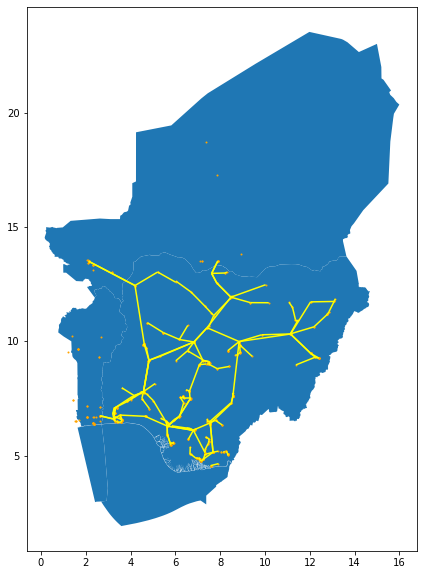

In [12]:
from shapely.geometry import LineString, Point

lines = n.lines[n.lines.country == "NG"].copy()
# lines = n.lines.copy()
lines["geometry"] = [LineString([Point(x.bus0_lon, x.bus0_lat), Point(x.bus1_lon, x.bus1_lat)]) for index, x in lines.iterrows() 
    if (x.bus0_lat is not None) and (x.bus0_lon is not None) and (x.bus1_lat is not None) and (x.bus1_lon is not None)]
lines = gpd.GeoDataFrame(geometry=lines.geometry, crs='epsg:4326')

continent = gpd.read_file('resources/country_shapes.geojson')
off_shore = gpd.read_file('resources/offshore_shapes.geojson')

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
c_code = "CD"
# lines[lines.country==c_code].plot(ax=ax, color="yellow")
# buses[buses.country==c_code].plot(ax=ax, color = "orange", markersize = 1)
lines.plot(ax=ax, color="yellow")
buses.plot(ax=ax, color = "orange", markersize = 1)

In [69]:
lines.country.unique()

array(['ZM', 'NG', 'UG', 'BF', 'ML', 'SZ', 'LS', 'ZA', 'MA', 'MW', 'GN',
       'GQ', 'SS', 'CI', 'NE', 'BW', 'BJ', 'MG', 'DJ', 'GA', 'ER', 'KE',
       'SL', 'BI', 'LY', 'ZW', 'TG', 'ET', 'CF', 'EG', 'RW', 'TZ', 'CM',
       'GH', 'CG', 'MR', 'MZ', 'AO', 'DZ', 'CD', 'SD', 'TN'], dtype=object)